<h1>CNN for to detect brain tumors using MRI images</h1>

In [81]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
import warnings
warnings.filterwarnings('ignore', category=UserWarning)


In [82]:
DATA_DIR = "data/raw"
TRAIN_DIR = "data/train/"
VAL_DIR = "data/val"
TEST_DIR = "data/test"
categories = ["yes", "no"]
img_size = (256, 256)
batch_size = 64


In [83]:
for dir_path in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    os.makedirs(dir_path, exist_ok=True)
    for category in categories:
        os.makedirs(os.path.join(dir_path, category), exist_ok=True)


In [84]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)


In [85]:
def split_and_move_data(data_dir, train_dir, val_dir, test_dir, categories):
    for category in categories:
        category_path = os.path.join(data_dir, category)
        images = os.listdir(category_path)
        train_images, temp_images = train_test_split(images, test_size=0.3, random_state=42)
        val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)
        for image_set, target_dir in [(train_images, train_dir), (val_images, val_dir), (test_images, test_dir)]:
            for image in image_set:
                shutil.copy(os.path.join(category_path, image), os.path.join(target_dir, category, image))

split_and_move_data(DATA_DIR, TRAIN_DIR, VAL_DIR, TEST_DIR, categories)


In [86]:
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=img_size, batch_size=batch_size,
    class_mode='binary'
)
val_generator = val_datagen.flow_from_directory(
    VAL_DIR, target_size=img_size, batch_size=batch_size,
    class_mode='binary'
)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR, target_size=img_size, batch_size=batch_size,
    class_mode='binary'
)


Found 2325 images belonging to 2 classes.
Found 662 images belonging to 2 classes.
Found 581 images belonging to 2 classes.


In [87]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))


In [88]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

checkpoint = ModelCheckpoint("best_model.keras", monitor='val_loss', save_best_only=True)


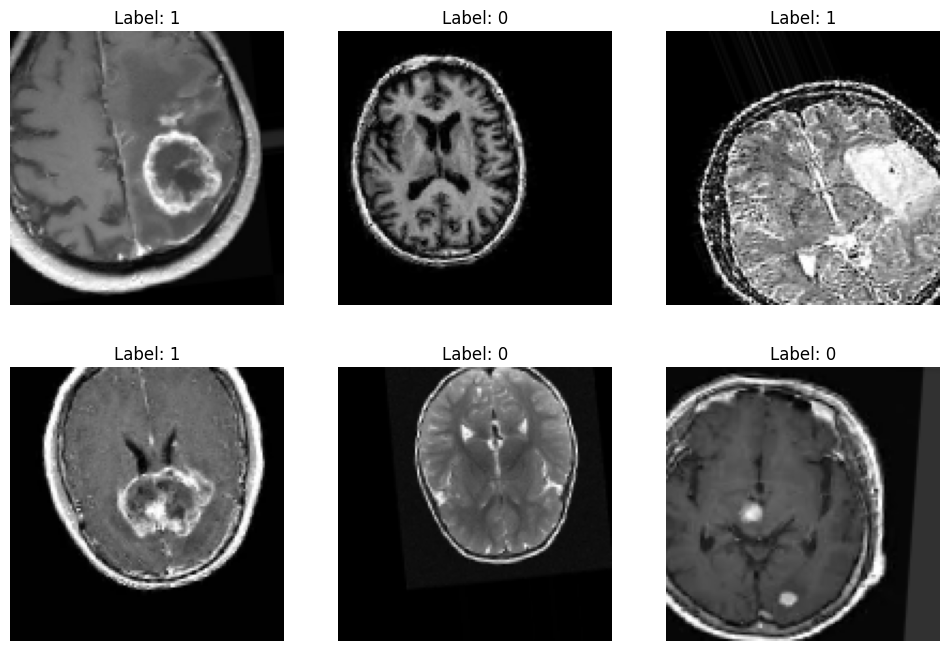

In [89]:
def visualize_images(generator):
    images, labels = next(generator)
    plt.figure(figsize=(12, 8))
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {int(labels[i])}")
        plt.axis('off')
    plt.show()

visualize_images(train_generator)


In [90]:
model = Sequential([
    Conv2D(32, (3, 3), input_shape=(img_size[0], img_size[1], 3)),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3)),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3)),
    LeakyReLU(alpha=0.1),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128),
    LeakyReLU(alpha=0.1),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


In [91]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    batch_size=batch_size,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    class_weight=class_weights
)


Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 38s 998ms/step - accuracy: 0.5382 - loss: 0.9466 - val_accuracy: 0.6903 - val_loss: 0.6197 - learning_rate: 0.0010
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 19s 502ms/step - accuracy: 0.6241 - loss: 0.6465 - val_accuracy: 0.6601 - val_loss: 0.5691 - learning_rate: 0.0010
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 19s 505ms/step - accuracy: 0.6637 - loss: 0.6115 - val_accuracy: 0.7764 - val_loss: 0.4886 - learning_rate: 0.0010
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 19s 508ms/step - accuracy: 0.6838 - loss: 0.6091 - val_accuracy: 0.7885 - val_loss: 0.4617 - learning_rate: 0.0010
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 19s 513ms/step - accuracy: 0.6808 - loss: 0.6057 - val_accuracy: 0.8082 - val_loss: 0.4370 - learning_rate: 0.0010
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 19s 520ms/step - accuracy: 0.7190 - loss: 0.5605 - val_accuracy: 0.8082 - val_loss: 0.4161 - learning_rate: 0.0010
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 19s 508ms/step - accuracy: 0.7420 - l

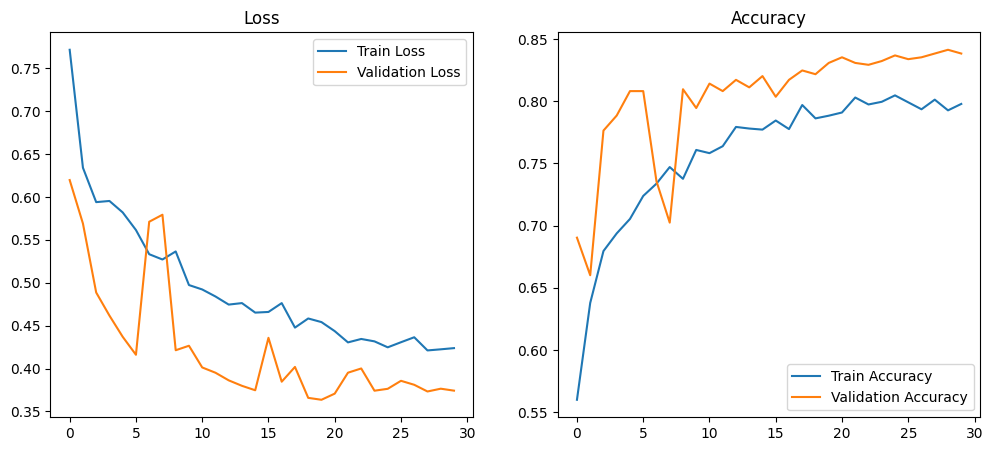

In [92]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.show()

plot_training_history(history)


In [93]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.2f}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 389ms/step - accuracy: 0.8110 - loss: 0.3844
Test Accuracy: 0.80
